# Bank Marketing Data - A Multilayer Perceptron (MLP) Approach

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### Install and Load Libraries

In [15]:
#!pip install wandb

In [16]:
# Imports
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from keras import callbacks
from keras.wrappers.scikit_learn import KerasClassifier

# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score
# imblearn

In [17]:
# Login to Weights & Biases
#!wandb login --relogin

# 1.0 Training



## 1.0.2 Holdout Configuration

In [19]:
# global variables

# ratio used to split train and validation data
val_size = 0.20
# seed used to reproduce purposes
seed = 41
# reference (column) to stratify the data
stratify = "y"
# name of the input artifact
artifact_input_name = "mlops_ivan/bank_mlp/train.csv:latest"
# type of the artifact
artifact_type = "Train"

In [20]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan", job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

14-07-2022 22:11:42 Downloading and reading train artifact
14-07-2022 22:11:45 Spliting data into train/val


In [21]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

14-07-2022 22:11:45 x train: (25317, 16)
14-07-2022 22:11:45 y train: (25317,)
14-07-2022 22:11:45 x val: (6330, 16)
14-07-2022 22:11:45 y val: (6330,)


## 1.1 Data preparation

### 1.1.1 Outlier Removal

In [22]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

14-07-2022 22:11:45 Outlier Removal


In [23]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

14-07-2022 22:11:45 x_train shape [original]: (25317, 16)
14-07-2022 22:11:45 x_train shape [outlier removal]: (24746, 16)


In [24]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

### 1.1.2 Imbalanced Classification

Reference:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [25]:
# for validation purposes
df = pd.concat([x_train, y_train], axis=1)
df.y.value_counts()

no     21970
yes     2776
Name: y, dtype: int64

In [26]:
# Return X and y balanced: oversample and undersample
def resaple_bal(x_train, y_train):
  # random_state=0 , (sampling_strategy="auto")
  oversample = SMOTENC(categorical_features=[1, 2, 3, 4, 6, 7, 8, 10, 15],  sampling_strategy = 0.5, random_state=seed)
  undersample = RandomUnderSampler(sampling_strategy="auto", random_state=seed)
  X, y = oversample.fit_resample(x_train, y_train)
  X, y = undersample.fit_resample(X, y)
  return X, y


In [27]:
x_train_bal, y_train_bal = resaple_bal( x_train, y_train)

In [28]:
# for validation purposes
df_bal = pd.concat([x_train_bal, y_train_bal], axis=1)
df_bal.y.value_counts()

(21970, 17)

### 1.1.3 Encoding Target Variable

In [30]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train_bal
y_train_bal = le.fit_transform(y_train_bal)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

14-07-2022 22:11:48 Encoding Target Variable
14-07-2022 22:11:48 Classes [0, 1]: ['no' 'yes']


## 1.2 Using a full-pipeline

#### 1.2.1 Feature Extractor

In [31]:
def copy_exception(feature_names, exceptions):
  # this functios return the itens in the feature_names except exceptions
  # if exceptions do not exist in feature_names it returns all feature_names
  # Imput: feature_names, exceptions: list
  # Output: list
  for exception in exceptions:
    try:
      feature_names.remove(exception)
    except ValueError:
      pass
    features_selected = feature_names
  return features_selected

In [32]:
f_sel = copy_exception(x_train_bal.select_dtypes("object").columns.to_list(), ["contact", "day"])
print(f_sel)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome']


In [33]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
      #exceptions = ["contact", "day", 'default', 'loan', 'marital']
      exceptions = ['default', 'loan']
      self.feature_names = copy_exception(feature_names, exceptions) 
      #self.feature_names = feature_names


    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:
            # df['job'] = df['job']
            # Combine similar jobs into categiroes
            df['job'] = df['job'].replace(['management', 'admin.'], 'white-collar')
            df['job'] = df['job'].replace(['services','housemaid'], 'pink-collar')
            df['job'] = df['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

            # minimize the cardinality poutcome
            df['poutcome'] = df['poutcome'].replace(['other'] , 'unknown')

            # Drop 'contact', as every participant has been contacted. 
            # df.drop('contact', axis=1, inplace=True)

            # day  : last contact day of the month
            # month: last contact month of year
            # Drop 'month' as they don't have any intrinsic meaning
            # df.drop('month', axis=1, inplace=True)
            df['month'] = df['month'].replace(['feb', 'mar', 'jan'], '1st')
            df['month'] = df['month'].replace(['may', 'jun', 'apr'], '2st')
            df['month'] = df['month'].replace(['jul', 'aug', 'sep'], '3st')
            df['month'] = df['month'].replace(['nov', 'oct', 'dec'], '4st')         

        # update column names
        self.colnames = df.columns

        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # day  : last contact day of the month                  # adicionado
        # Drop 'day' as they don't have any intrinsic meaning
        # df.drop('day', axis=1, inplace=True)

        # Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
        df.loc[df['pdays'] == -1, 'pdays'] = 10000

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [34]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train_bal)
df.head()

,job,marital,education,housing,contact,month,poutcome
0,technician,married,secondary,no,unknown,jun,unknown
1,blue-collar,married,primary,yes,unknown,may,unknown
2,services,single,secondary,yes,unknown,jun,unknown
3,management,married,tertiary,yes,cellular,jun,unknown
4,blue-collar,single,secondary,yes,cellular,jul,unknown


In [35]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train_bal)
df.head()

,age,balance,day,duration,campaign,pdays,previous
0,41,0,20,850,3,-1,0
1,42,163,29,62,6,-1,0
2,28,3575,3,245,1,-1,0
3,34,1870,3,68,1,-1,0
4,35,3508,15,94,3,-1,0


#### 1.2.2 Handling Categorical Features

In [36]:
x_train_bal.month.unique()

array(['jun', 'may', 'jul', 'jan', 'oct', 'apr', 'aug', 'feb', 'nov',
       'dec', 'sep', 'mar'], dtype=object)

In [37]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train_bal)
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,housing,contact,month,poutcome
0,technician,married,secondary,no,unknown,2st,unknown
1,blue-collar,married,primary,yes,unknown,2st,unknown
2,pink-collar,single,secondary,yes,unknown,2st,unknown
3,white-collar,married,tertiary,yes,cellular,2st,unknown
4,blue-collar,single,secondary,yes,cellular,3st,unknown


In [38]:
# check the cardinality before and after transformation
x_train_bal.select_dtypes("object").apply(pd.Series.nunique)

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [39]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

job          7
marital      3
education    4
housing      2
contact      3
month        4
poutcome     3
dtype: int64

#### 1.2.3 Handling Numerical Features

In [40]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train_bal)
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[ 1.29389941e-02, -5.23551500e-01,  5.95803777e-01, ...,
         2.53084862e-01,  1.00830099e+02, -3.77379793e-01],
       [ 1.04285299e-01, -4.67018821e-01,  1.74616293e+00, ...,
         1.44151627e+00,  1.00830099e+02, -3.77379793e-01],
       [-1.17456297e+00,  7.16352357e-01, -1.57709685e+00, ...,
        -5.39202743e-01,  1.00830099e+02, -3.77379793e-01],
       ...,
       [-7.17831447e-01, -5.18695933e-01, -4.26737692e-01, ...,
        -5.39202743e-01,  1.00830099e+02, -3.77379793e-01],
       [-4.43792531e-01,  2.82819540e-01, -1.71102325e-01, ...,
        -5.39202743e-01,  9.71927957e-01,  2.23429854e+00],
       [ 1.65717249e+00, -3.59155856e-01,  7.23621461e-01, ...,
        -5.39202743e-01,  1.00830099e+02, -3.77379793e-01]])

In [42]:
# return columns name
nt.get_feature_names_out()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#### 1.2.4 Data Preparation Pipeline

In [43]:
print(x_train_bal.select_dtypes("object").columns.to_list())

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [44]:
print(x_train_bal.select_dtypes("int64").columns.to_list())

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [45]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 2

# Categrical features to pass down the categorical pipeline
categorical_features = x_train_bal.select_dtypes("object").columns.to_list() 

# Numerical features to pass down the numerical pipeline
numerical_features = x_train_bal.select_dtypes("int64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="if_binary"))
                                       ]
                                ) # drop="first"

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [46]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train_bal)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = cat_names + num_names)
df.head()

,job_blue-collar,job_entrepreneur,job_other,job_pink-collar,job_self-employed,job_technician,job_white-collar,marital_divorced,marital_married,marital_single,...,poutcome_failure,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,41.0,0.0,20.0,850.0,3.0,10000.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,42.0,163.0,29.0,62.0,6.0,10000.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,28.0,3575.0,3.0,245.0,1.0,10000.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,34.0,1870.0,3.0,68.0,1.0,10000.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,35.0,3508.0,15.0,94.0,3.0,10000.0,0.0


In [47]:
print(df.columns.to_list())

['job_blue-collar', 'job_entrepreneur', 'job_other', 'job_pink-collar', 'job_self-employed', 'job_technician', 'job_white-collar', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'housing_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_1st', 'month_2st', 'month_3st', 'month_4st', 'poutcome_failure', 'poutcome_success', 'poutcome_unknown', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [48]:
print(new_data.shape)

(21970, 32)


## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains preprocesing pipeline)
- le (label encoder object used to encode the target variable)
- keras model (contains keras model artifact)

In [49]:
def nn_model():	
  # define model
  model = Sequential()
  model.add(Dense(120, input_dim=32, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(60, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt =  'adam'
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [50]:
# The full pipeline 

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',   # 'loss'             
                min_delta=0.001, # Minimum change
                patience=50, # Number of epochs with no improvement
                verbose=1, # 
                mode='auto', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

model = nn_model()

x_val_trans = full_pipeline_preprocessing.transform(x_val)

# training
logger.info("Training")
# fit model on train set
history = model.fit(new_data, y_train_bal,
                    epochs=20,
                    verbose=1,
                    #batch_size=512,
                    validation_data=(x_val_trans, y_val ),
                    callbacks=[early_stopping]
                    )


14-07-2022 22:11:49 Training


Epoch 1/20
687/687 [==============================] - 1s 894us/step - loss: 28.7882 - accuracy: 0.6745 - val_loss: 25.0709 - val_accuracy: 0.3074
Epoch 2/20
687/687 [==============================] - 1s 749us/step - loss: 17.6661 - accuracy: 0.6880 - val_loss: 11.9411 - val_accuracy: 0.7836
Epoch 3/20
687/687 [==============================] - 1s 752us/step - loss: 12.9668 - accuracy: 0.7046 - val_loss: 6.9443 - val_accuracy: 0.8855
Epoch 4/20
687/687 [==============================] - 1s 759us/step - loss: 13.1126 - accuracy: 0.7088 - val_loss: 6.9179 - val_accuracy: 0.7450
Epoch 5/20
687/687 [==============================] - 1s 752us/step - loss: 11.7992 - accuracy: 0.7127 - val_loss: 7.1858 - val_accuracy: 0.7810
Epoch 6/20
687/687 [==============================] - 1s 786us/step - loss: 8.5936 - accuracy: 0.7280 - val_loss: 7.1912 - val_accuracy: 0.7703
Epoch 7/20
687/687 [==============================] - 1s 764us/step - loss: 10.8948 - accuracy: 0.7176 - val_loss: 4.4381 - val_a



---



In [51]:
# evaluate model on test set
_, test_acc = model.evaluate(full_pipeline_preprocessing.transform(x_val), y_val, verbose=1)

198/198 [==============================] - 0s 487us/step - loss: 0.8903 - accuracy: 0.8795


In [52]:
# Evaluation Metrics
def ful_pipe_predict(X):
    X_trans = full_pipeline_preprocessing.transform(X)
    X_pred = model.predict(X_trans)
    X_pred_rint = np.rint(X_pred)
    return X_pred_rint

logger.info("Infering")
y_pred = ful_pipe_predict(x_val)


14-07-2022 22:12:00 Infering


198/198 [==============================] - 0s 437us/step


In [53]:
# Evaluation Metrics

logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, y_pred, beta=1, zero_division=1)
precision = precision_score(y_val, y_pred, zero_division=1)
recall = recall_score(y_val, y_pred, zero_division=1)
acc = accuracy_score(y_val, y_pred)
g_mean = geometric_mean_score(y_val, y_pred)


logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))
logger.info("G-Mean: {}".format(g_mean))

14-07-2022 22:12:00 Evaluation metrics
c:\Users\franc\.conda\envs\colab2deploy\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
14-07-2022 22:12:00 Accuracy: 0.8794628751974723
14-07-2022 22:12:00 Precision: 0.48531289910600256
14-07-2022 22:12:00 Recall: 0.5135135135135135
14-07-2022 22:12:00 F1: 0.49901510177281677
14-07-2022 22:12:00 G-Mean: 0.6902845586000088


In [56]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      5590
           1       0.49      0.51      0.50       740

    accuracy                           0.88      6330
   macro avg       0.71      0.72      0.72      6330
weighted avg       0.88      0.88      0.88      6330



In [54]:
model.summary() # mostra modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               3960      
                                                                 
 dense_1 (Dense)             (None, 60)                7260      
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 11,281
Trainable params: 11,281
Non-trainable params: 0
_________________________________________________________________


In [55]:
casa = casacaiada

NameError: name 'casacaiada' is not defined

In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
artifact_model = "sdsd"
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="Neural Network Model for Classification Purpose"
                          )

logger.info("Logging model artifact")
model.save("path")
artifact.add_dir("path")
run.log_artifact(artifact)

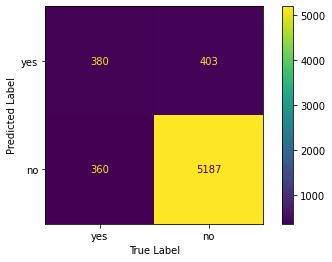

In [57]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(y_pred,y_val,labels=[1,0]),
                       display_labels=["yes","no"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
dt6_score_train = pipe.score(x_train_bal, y_train_bal)
print("Training score: ",dt6_score_train)
dt6_score_test = pipe.score(x_val, y_val)
print("Testing score: ",dt6_score_test)

In [ ]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train_bal),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train_bal,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

In [ ]:
# Visualize single plot
# wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [ ]:
# Catch up the class proportions between train and validation
# wandb.sklearn.plot_class_proportions(y_train_bal, y_val, [0,1])

In [ ]:
# Plot the importance of columns
# wandb.sklearn.plot_feature_importances(pipe.get_params()["classifier"],all_names)

In [ ]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
# wandb.sklearn.plot_summary_metrics(pipe.get_params()["classifier"],
#                                    full_pipeline_preprocessing.transform(x_train_bal),
#                                    y_train_bal,
#                                    full_pipeline_preprocessing.transform(x_val),
#                                    y_val)

In [ ]:
# ROC curve
# predict_proba = pipe.predict_proba(x_val)
# wandb.sklearn.plot_roc(y_val, predict_proba, [0,1])

In [ ]:
# close the current run before to execute the next section
run.finish()

## 1.6 Hyperparameter Tuning

In [ ]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [ ]:
# global seed
seed = 41

In [ ]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
            },
        "max_depth": {
            "values": [5, 7, 9]
            },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="bank_mlp", entity="mlops_ivan")

In [ ]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__max_depth": run.config.max_depth})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train_bal, y_train_bal)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [ ]:
wandb.agent(sweep_id, train, count=24)

## 1.7 Configure and train the best model

In [ ]:
# Note that a new run is yet synced to last sweep run
# Just to check
# run = wandb.init()

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.4.3```, ```1.4.4```, ```1.5``` and ```1.6```. 

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="train")

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
# pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 1})
# pipe.set_params(**{"classifier__criterion": 'entropy'})
# pipe.set_params(**{"classifier__splitter": 'random'})
# pipe.set_params(**{"classifier__max_depth": 6})
# pipe.set_params(**{"classifier__random_state": 41})

pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'gini'})
pipe.set_params(**{"classifier__splitter": 'best'})
pipe.set_params(**{"classifier__max_depth": 6})
pipe.set_params(**{"classifier__class_weight": {0:1.0, 1:6.0}})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train_bal, y_train_bal)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train_bal),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train_bal,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

## 1.8 Export the best model

In [ ]:
model.evaluate(testX, testY_one_hot)[1]

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')

In [ ]:
# pipe = Pipeline(steps =  [
#                          ('full_pipeline', full_pipeline_preprocessing),
#                          ("classifier", model)
#                          ])

In [60]:
pipe = full_pipeline_preprocessing

In [58]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"
artifact_keras_model = "keras_model_export"

In [61]:
logger.info("Dumping the artifacts to disk")
# Save the pipiline preprocessing using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

joblib.dump(model, artifact_keras_model)

14-07-2022 22:27:17 Dumping the artifacts to disk


INFO:tensorflow:Assets written to: ram://41d975a6-767c-4d05-9e8f-c6057032a0ca/assets


14-07-2022 22:27:17 Assets written to: ram://41d975a6-767c-4d05-9e8f-c6057032a0ca/assets


['keras_model_export']

In [62]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and MLP bank marketing model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

14-07-2022 22:27:28 Logging model artifact


In [63]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

14-07-2022 22:27:34 Logging target enconder artifact


In [64]:
# Model artifact
artifact = wandb.Artifact(artifact_keras_model,
                          type=artifact_type,
                          description="MLP Model for Classification Purpose"
                          )

logger.info("Logging keras model artifact")
model.save("path")
artifact.add_dir("path")
run.log_artifact(artifact)

14-07-2022 22:27:38 Logging keras model artifact


INFO:tensorflow:Assets written to: path\assets


14-07-2022 22:27:38 Assets written to: path\assets
wandb: Adding directory to artifact (.\path)... Done. 0.0s


In [65]:
run.finish()

## Save keras model on run

In [ ]:
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="save")

In [ ]:
model.save(os.path.join(wandb.run.dir, "model.h5"))

In [ ]:
run.finish()

## Load Keras Model Restore

In [ ]:
import tensorflow as tf

best_model = wandb.restore('model.h5', run_path="mlops_ivan/bank_mlp/akrq1ozh")
# restore the model for tf.keras
model = tf.keras.models.load_model(best_model.name)

In [ ]:
pred = model.predict(x_val_trans)
pred

## Load Keras Model Artifact

In [66]:
import keras

In [67]:
artifact_model_path = "mlops_ivan/bank_mlp/keras_model_export:latest"

# use the latest version of the model
model_at = run.use_artifact(artifact_model_path)
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model_t = keras.models.load_model(model_dir)

model:  .\artifacts\keras_model_export-v2


In [69]:
model_t.predict(x_val_trans)

198/198 [==============================] - 0s 492us/step


array([[2.0328511e-05],
       [1.5455719e-23],
       [1.1265925e-08],
       ...,
       [1.0430563e-17],
       [1.0898442e-03],
       [2.3308472e-04]], dtype=float32)

# 2.0 Test evaluation

## 2.1 Evaluation

In [ ]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "mlops_ivan/bank_mlp/test.csv:latest"

# name of the model artifact
artifact_model_name =  "mlops_ivan/bank_mlp/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name =  "mlops_ivan/bank_mlp/target_encoder:latest"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="test")

In [ ]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("y")

In [ ]:
# Takes a look at test set
x_test.head()

In [ ]:
# Take a look at the target variable
y_test.head()

In [ ]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

In [ ]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

In [ ]:
# target variable after the encoding
y_test

In [ ]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

In [ ]:
# predict
logger.info("Infering")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=[">50k","<=50k"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
run.finish()